# Clifford Decomposition

Here we will use the ``` near_clifford_solver.circuit_clifford_decomposition ``` function, which returns a list of all $f*2^{\# non-Clifford}$ circuits approximating a near-Clifford input, for fidelity f.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cirq
import bgls

First we just define some helper functions to quantify how well our results match either each other or the predicted distribution:

In [2]:
def result_overlap(a: cirq.ResultDict, b: cirq.ResultDict):
    # returns the fraction of results in a matching those in b. i.e. go through every result in a, see if there's a new result that is the same in b
    total_measurements = 0
    matching_measurements = 0
    used_b_indices = []  # keep track so no double counting, unique results
    for (gate_key, results) in a.measurements.items():
        try:
            b_res = b.measurements[gate_key]
        except:
            print("key not found in second results")
            return 0
        for repa in range(results.shape[0]):
            total_measurements += 1
            for repb in range(b_res.shape[0]):
                if (results[repa, :] == b_res[repb,
                                        :]).all() and not repb in used_b_indices:
                    matching_measurements += 1
                    used_b_indices.append(repb)
                    break

    return matching_measurements / total_measurements



In [3]:
def theoretic_overlap(prob_vec: np.ndarray, result: cirq.Result):
    # returns the percent overlap of sample results with the exact probability from the state vector
    # i.e. the fraction of our results that match the ideal sample distribution
    num_matches = 0
    count = result.histogram(key="meas")
    tot_samples = sum(count.values())
    for (bitstr, cnt) in count.items():
        theoretic_cnt = int(prob_vec[int(bitstr)] * tot_samples)
        num_matches += min(cnt, theoretic_cnt)

    return num_matches / tot_samples


def exact_overlaps(prob_vec1: np.ndarray, prob_vec2: np.ndarray):
    # gives the corresponding overlap for two final state vectors, to be used when one is an approximation
    total_prob_match = 0.
    for i in range(len(prob_vec1)):
        total_prob_match += min(np.abs(prob_vec1[i]), np.abs(prob_vec2[i]))
    return total_prob_match  #(max possible is exact match hence total 1)

We first show how we can sample from our expanded list of exact-Clifford circuits approximating the original near-Clifford:

In [4]:
# initialize random circuit with e.g. Clifford+T gates:
qubits = cirq.LineQubit.range(3)
domain = {cirq.H, cirq.CNOT, cirq.S, cirq.T}
clifford_circuit = bgls.utils.generate_random_circuit(
    qubits,
    n_moments=10,
    op_density=0.5,
    gate_domain=domain,
    random_state=2,
)
clifford_circuit.append(cirq.measure(qubits, key="meas"))
# and generate the strict Clifford expansion, keeping all terms:
(expanded_circuits,
 expanded_amplitudes) = bgls.near_clifford_solver.circuit_clifford_decomposition(
    clifford_circuit, fidelity=1.0)


We compare sampling with cirq or bgls as we have done before:

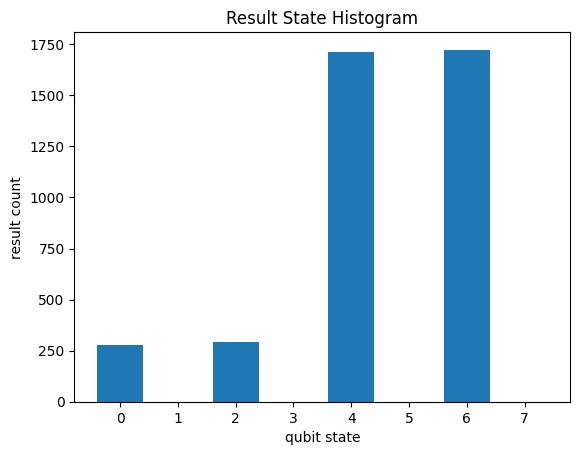

overlap with ideal distribution: 0.995
[0.07322329 0.         0.07322329 0.         0.4267766  0.
 0.4267766  0.        ]


In [26]:
# strict sampling of the original circuit:
cirq_sim = cirq.Simulator()
cirq_result = cirq_sim.run(clifford_circuit, repetitions=1000 * len(
    expanded_circuits))  # to match number of trials with expanded
vec = np.power(np.abs(cirq_sim.simulate(clifford_circuit[:-1]).final_state_vector),
               2)
overlap = theoretic_overlap(vec, cirq_result)
_ = cirq.plot_state_histogram(cirq_result, plt.subplot())
plt.show()
print("overlap with ideal distribution: " + str(overlap))
print("final state vector: ", vec)

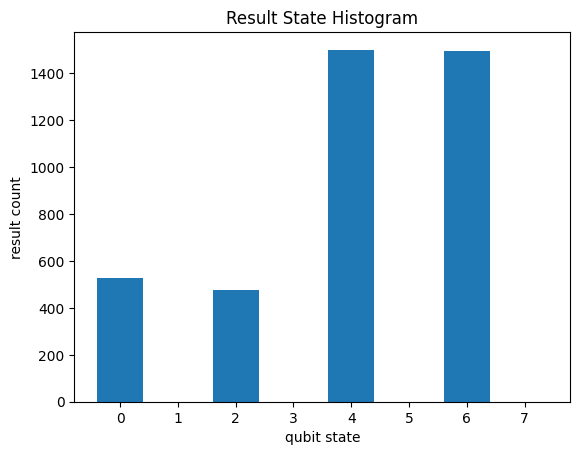

overlap with ideal distribution: 0.8955


In [27]:
# first repeat randomly len(expanded_circuits) number of trials with our standard bgls near-clifford simulator, as per usual
bgls_sim = bgls.Simulator(
    cirq.StabilizerChFormSimulationState(
        qubits=qubits, initial_state=0
    ),
    bgls.apply.act_on_near_clifford,
    bgls.born.cirq_stabilizer_ch_bitstring_probability,
    seed=2
)
bgls_result = bgls_sim.run(clifford_circuit,
                           repetitions=1000 * len(expanded_circuits))
_ = cirq.plot_state_histogram(bgls_result, plt.subplot())
plt.show()
overlap = theoretic_overlap(vec, bgls_result)
print("overlap with ideal distribution: " + str(overlap))

We contrast this with running on each circuit in the expansion as follows. First we can try sampling from each, to ensure all paths are covered:

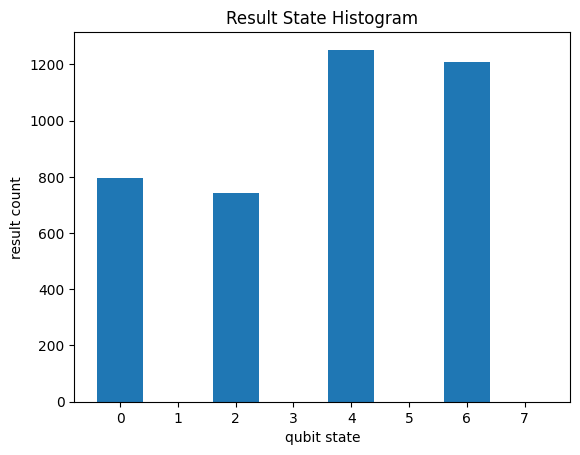

overlap with ideal distribution: 0.7615


In [28]:
expanded_results = None
for c in expanded_circuits:
    if expanded_results is None:
        expanded_results = bgls_sim.run(c, repetitions=1000)
    else:
        expanded_results += bgls_sim.run(c, repetitions=1000)
_ = cirq.plot_state_histogram(expanded_results, plt.subplot())
plt.show()
overlap = theoretic_overlap(vec, expanded_results)
print("overlap with ideal distribution: " + str(overlap))

We note that this may actually recreate the original distribution worse than repeated sampling from the original circuit. This is because whereas the latter yields samples distributed according to the relative amplitudes even if it doesn't explore the entire space, this method samples from all paths equally, not capturing their varying amplitude. We can try to reincorporate this as follows.

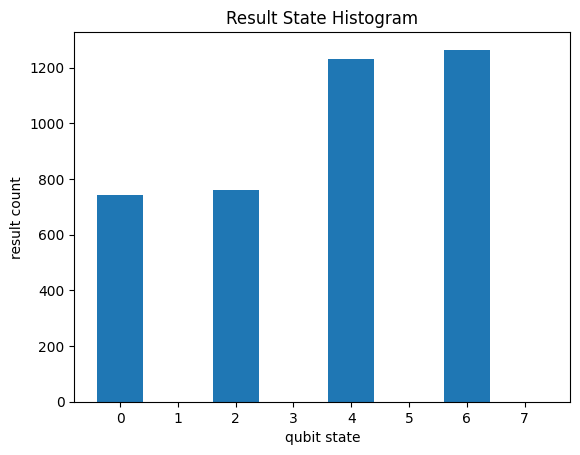

overlap with ideal distribution: 0.76975


In [29]:
weighted_expanded_results = None
rng = np.random.RandomState()
expanded_probabilities = np.power(np.abs(expanded_amplitudes), 2)
for rep in range(len(expanded_circuits)):
    chosen_circuit = rng.choice(len(expanded_circuits),
                                p=expanded_probabilities / sum(
                                    expanded_probabilities))
    c = expanded_circuits[chosen_circuit]
    if weighted_expanded_results is None:
        weighted_expanded_results = bgls_sim.run(c, repetitions=1000)
    else:
        weighted_expanded_results += bgls_sim.run(c, repetitions=1000)
_ = cirq.plot_state_histogram(weighted_expanded_results, plt.subplot())
plt.show()
overlap = theoretic_overlap(vec, weighted_expanded_results)
print("overlap with ideal distribution: " + str(overlap))

We know that our decomposition is optimal, but that does not mean it is always very good. We can pick a gate very close to clifford and see if results match the exact case better. For example Rz(theta=epsilon)

In [30]:
epsilon = 1e-8

def f(op):
    if isinstance(op.gate,
                  cirq.ops.common_gates.ZPowGate) and op.gate.exponent == 0.25:
        qubits = op.qubits[0]
        return cirq.Rz(rads=epsilon).on(qubits)
    else:
        return op

Rze = clifford_circuit.map_operations(f)
(expanded_Rze,
 Rze_amplitudes) = bgls.near_clifford_solver.circuit_clifford_decomposition(
    Rze, fidelity=1.0)

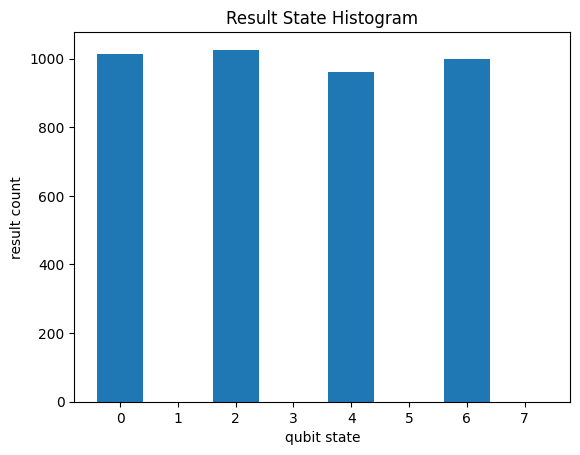

overlap with ideal distribution: 0.9895


In [31]:
cirq_result = cirq_sim.run(Rze, repetitions=1000 * len(expanded_circuits))
vec = np.power(np.abs(cirq_sim.simulate(Rze[:-1]).final_state_vector),
               2)
_ = cirq.plot_state_histogram(cirq_result, plt.subplot())
plt.show()
overlap = theoretic_overlap(vec, cirq_result)
print("overlap with ideal distribution: " + str(overlap))

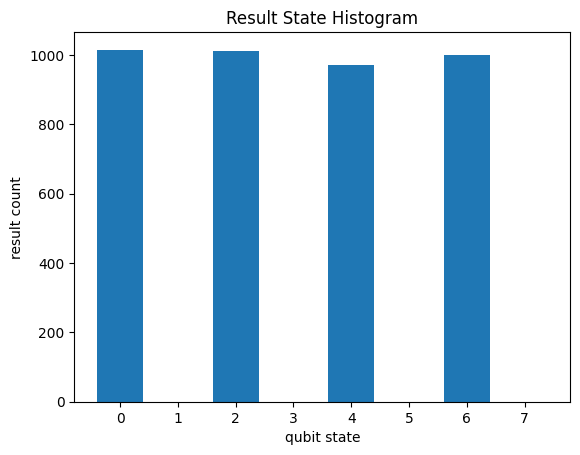

overlap with ideal distribution: 0.99225


In [32]:
bgls_result = bgls_sim.run(Rze, repetitions=1000 * len(expanded_circuits))
_ = cirq.plot_state_histogram(bgls_result, plt.subplot())
plt.show()
overlap = theoretic_overlap(vec, bgls_result)
print("overlap with ideal distribution: " + str(overlap))

We are now ready to quantify this and explore the larger behavior. First we create a Clifford+T circuit, as well as an exact Clifford circuit. We run over an increasing number of samples both circuits for both the exact cirq StateVector simulator and our bgls sampler (i.e. it is exact in the Clifford case and approximate in the Clifford+T case).

In [5]:
compq = cirq.LineQubit.range(3)
domain = {cirq.H, cirq.CNOT, cirq.S, cirq.T}
comp_circuit = bgls.utils.generate_random_circuit(
    compq,
    n_moments=10,
    op_density=0.5,
    gate_domain=domain,
    random_state=2
)
comp_circuit.append(cirq.measure(compq, key="meas"))

def f(op):
    if isinstance(op.gate,
                  cirq.ops.common_gates.ZPowGate) and op.gate.exponent == 0.25:
        qubits = op.qubits[0]
        return cirq.S.on(qubits)
    else:
        return op

comp_circuit_clifford = comp_circuit.map_operations(f)

bgls_sim = bgls.Simulator(
    cirq.StabilizerChFormSimulationState(
        qubits=compq, initial_state=0
    ),
    bgls.apply.act_on_near_clifford,
    bgls.born.cirq_stabilizer_ch_bitstring_probability,
    seed=1
)
cirq_sim = cirq.Simulator()

overlapscirq = []
overlapsbgls = []
overlapscirq_clifford = []
overlapsbgls_clifford = []

reps = np.linspace(start=10, stop=1500, num=8, dtype=int)
for rep in reps:
    ressim = cirq_sim.simulate(comp_circuit[:-1])
    vec = np.power(np.abs(ressim.final_state_vector), 2)

    res = cirq_sim.run(comp_circuit, repetitions=rep)
    overlapscirq.append(theoretic_overlap(vec, res))
    resbgls = bgls_sim.run(comp_circuit, repetitions=rep)
    overlapsbgls.append(theoretic_overlap(vec, resbgls))

    ressim_clifford = cirq_sim.simulate(comp_circuit_clifford[:-1])
    vec_clifford = np.power(np.abs(ressim_clifford.final_state_vector), 2)

    res_clifford = cirq_sim.run(comp_circuit_clifford, repetitions=rep)
    overlapscirq_clifford.append(theoretic_overlap(vec_clifford, res_clifford))
    resbgls_clifford = bgls_sim.run(comp_circuit_clifford, repetitions=rep)
    overlapsbgls_clifford.append(
        theoretic_overlap(vec_clifford, resbgls_clifford))


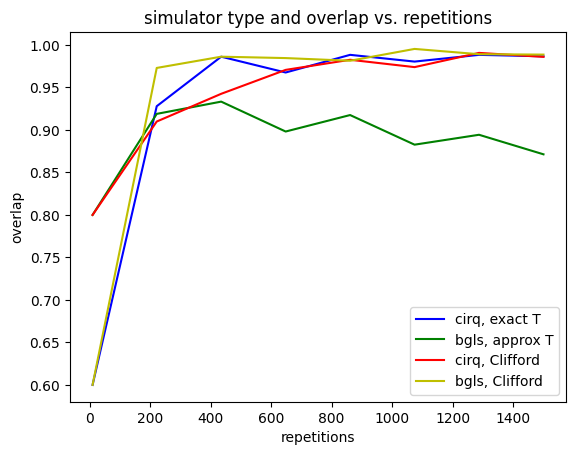

In [7]:
_ = plt.plot(reps, overlapscirq, color="b", label="cirq, exact T")
_ = plt.plot(reps, overlapsbgls, color="g", label="bgls, approx T")
_ = plt.plot(reps, overlapscirq_clifford, color="r", label="cirq, Clifford")
_ = plt.plot(reps, overlapsbgls_clifford, color="y", label="bgls, Clifford")
plt.legend()
plt.xlabel(xlabel="repetitions")
plt.ylabel(ylabel="overlap")
plt.title(label="simulator type and overlap vs. repetitions")
plt.show()

We see that all simulators tend towards 1.0 overlap with the ideal as the number of samples increases hence fluctuations decrease. However, while bgls follows cirq in the exact Clifford case, we see that the bgls lags in the Clifford+T circuit. This is the price we pay for simulating it as an exact-Clifford approximation (one would lose the benefit of working with a clifford simulator if using cirq).

Next we similarly sweep across the angle used in the Rz gate of the circuit, again running on the exact cirq sampler vs the Clifford-approximate bgls sampler.

In [8]:
overlapscirq = []
overlapsbgls = []
thetas = np.linspace(-4, 3, num=10)
for i in thetas:
    def f(op):
        if isinstance(op.gate,
                      cirq.ops.common_gates.ZPowGate) and op.gate.exponent == 0.25:
            qubits = op.qubits[0]
            return cirq.Rz(rads=i).on(qubits)
        else:
            return op


    Rzi = comp_circuit.map_operations(f)

    res = cirq_sim.run(Rzi, repetitions=1000)
    ressim = cirq_sim.simulate(Rzi[:-1])
    vec = np.power(np.abs(ressim.final_state_vector), 2)
    overlapscirq.append(theoretic_overlap(vec, res))

    resbgls = bgls_sim.run(Rzi, repetitions=1000)
    overlapsbgls.append(theoretic_overlap(vec, resbgls))


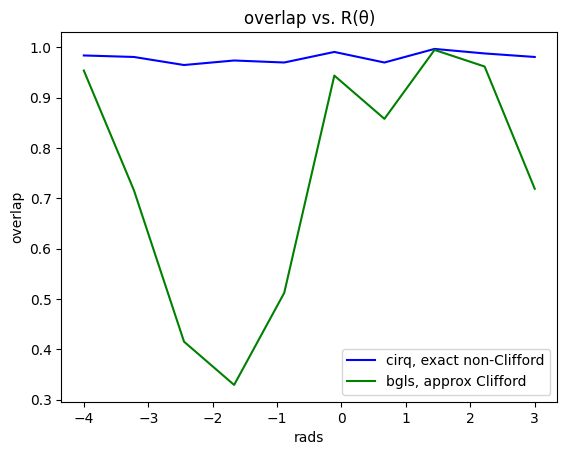

In [12]:
_ = plt.plot(thetas, overlapscirq, color="b", label="cirq, exact non-Clifford")
_ = plt.plot(thetas, overlapsbgls, color="g", label="bgls, approx Clifford")
plt.legend()
plt.xlabel(xlabel="rads")
plt.ylabel(ylabel="overlap")
plt.title(label="overlap vs. R(θ)")
plt.show()

We see there is a clear fluctuation in overlap as a function of Rz angle, as can be compared with a plot of the error metric used in the original paper.

Finally, we can investigate varying the fidelity of our exact Clifford expansion. For the bgls sampler this has no use, but with an exact *simulator* (e.g. cirq's ```simulate``` vs ```run``` functions), one can fully simulate each of the sub circuits and sum the final state vector, allowing a speedup in exact simulation at the cost of output accuracy.

In [43]:
cliffq = cirq.LineQubit.range(3)
domain = {cirq.H, cirq.CNOT, cirq.S, cirq.T}
cliff_circuit = bgls.utils.generate_random_circuit(
    cliffq,
    n_moments=20,
    op_density=0.5,
    gate_domain=domain,
    random_state=2
)
cliff_circuit.append(cirq.measure(cliffq, key="meas"))

cirq_clifford_sim = cirq.CliffordSimulator()
cirq_exact_sim = cirq.Simulator()
exact_sim = cirq_exact_sim.simulate(cliff_circuit)
exact_vec = exact_sim.final_state_vector

overlaps = []

fidelities = np.linspace(0., 1., 10)
for fidelity in fidelities:
    final_state_vec = np.zeros_like(exact_vec)
    (expanded_cliff,
     cliff_amplitudes) = bgls.near_clifford_solver.circuit_clifford_decomposition(
        cliff_circuit, fidelity=fidelity)
    for i in range(len(expanded_cliff)):
        (c, a) = expanded_cliff[i], cliff_amplitudes[i]
        state = cirq_clifford_sim.simulate(c)
        final_state_vec += a * state.final_state.state_vector()

    final_prob_vec = np.power(np.abs(final_state_vec), 2)
    overlaps.append(
        exact_overlaps(np.power(np.abs(exact_vec), 2), final_prob_vec))


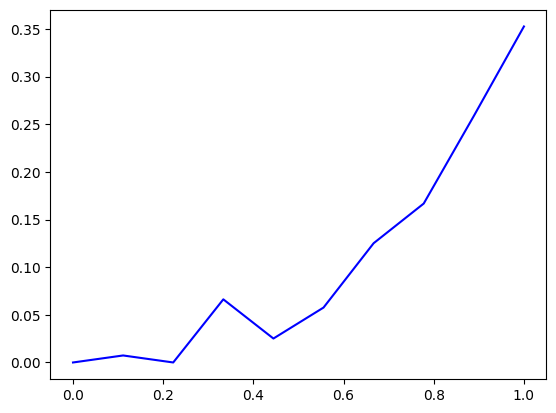

In [44]:
_ = plt.plot(fidelities, overlaps, color="b")
plt.show()

We thus see that retaining more terms in the expansion grants an increase in accuracy at the cost of increasing computational time. What is gained with such a decomposition is the ability to use more a efficient *pure-Clifford* simulator on each sub-circuit, allowing performance gains over exact simulation of the original non-Clifford circuit.